## Spark Data: Open Air Quality data set, reading data from S3

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

### Download and initialize Spark

In [ ]:
# Install OpenJDK 8 (Spark still works well with Java 8, though Java 11 is also supported)
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

# Download Spark 3.5.1 with Hadoop 3.3
!wget -q https://archive.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar -xvf spark-3.5.1-bin-hadoop3.tgz > /dev/null

# Install findspark and seaborn quietly
!pip install -q findspark > /dev/null
!pip install seaborn > /dev/null

!wget -q https://repo1.maven.org/maven2/org/apache/hadoop/hadoop-aws/3.3.4/hadoop-aws-3.3.4.jar -P /content/spark-3.5.1-bin-hadoop3/jars/
!wget -q https://repo1.maven.org/maven2/com/amazonaws/aws-java-sdk-bundle/1.12.262/aws-java-sdk-bundle-1.12.262.jar -P /content/spark-3.5.1-bin-hadoop3/jars/

# Install pyngrok (for exposing Spark UI)
!pip install pyngrok > /dev/null


gzip: stdin: unexpected end of file
tar: Unexpected EOF in archive
tar: Unexpected EOF in archive
tar: Error is not recoverable: exiting now


In [ ]:
# Set up environment variables for Spark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.5.1-bin-hadoop3"

# Initialize findspark and start a SparkSession
import findspark
findspark.init()
from pyspark.sql import SparkSession

# Create SparkSession
spark = SparkSession.builder \
    .appName("UpdatedSparkApp") \
    .getOrCreate()

# Verify the Spark version
print("Spark Version:", spark.version)

Exception: Unable to find py4j in /content/spark-3.5.1-bin-hadoop3/python, your SPARK_HOME may not be configured correctly

In [ ]:
# Optional: use ngrok to expose Spark GUI (requires ngrok account)
from pyngrok import ngrok, conf
import getpass

print("Enter your authtoken, which can be copied "
"from https://dashboard.ngrok.com/get-started/your-authtoken")
conf.get_default().auth_token = getpass.getpass()

ui_port = 4040
public_url = ngrok.connect(ui_port).public_url
print(f" * ngrok tunnel \"{public_url}\" -> \"http://127.0.0.1:{ui_port}\"")

Enter your authtoken, which can be copied from https://dashboard.ngrok.com/get-started/your-authtoken
··········


 * ngrok tunnel "https://a200-104-196-210-178.ngrok-free.app" -> "http://127.0.0.1:4040"


### Configure AWS credentials


**Important**: you need to copy your AWS credentials to file named `aws_credentials`. Format:
```
aws_access_key_id=<access_key>
aws_secret_access_key=<secret_key>
aws_session_token=<session_token>
```
In AWS Academy you can find your credentials under AWS Details -> AWS CLI -> Show button

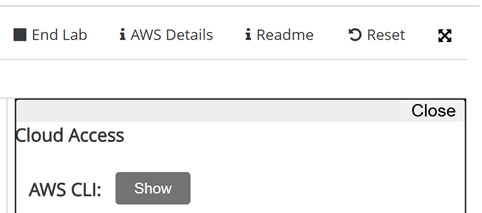

In [ ]:
# Read credentials from the file
credentials = {}
with open("/content/aws_credentials", "r") as f:
    for line in f:
        key, value = line.strip().split("=", 1)
        credentials[key] = value

# Extract credentials
AWS_ACCESS_KEY = credentials["aws_access_key_id"]
AWS_SECRET_KEY = credentials["aws_secret_access_key"]
AWS_SESSION_TOKEN = credentials["aws_session_token"]

In [ ]:
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.access.key", AWS_ACCESS_KEY)
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.secret.key", AWS_SECRET_KEY)
spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.session.token", AWS_SESSION_TOKEN)
# Additional S3A configuration (optional but recommended)
# spark.sparkContext._jsc.hadoopConfiguration().set("fs.s3a.impl", "org.apache.hadoop.fs.s3a.S3AFileSystem")

### Reading OpenAQ data from AWS S3

OpenAQ project: https://openaq.org/

Registry of AWS Open Data: https://registry.opendata.aws/openaq/

S3 bucket structure: https://docs.openaq.org/aws/about

Now we can read a small sample of data:

In [ ]:
smog_df = spark \
    .read \
    .format("csv") \
    .option("compression", "gzip") \
    .option("header", True) \
    .load("s3a://openaq-data-archive/records/csv.gz/locationid=100*/year=2022/month=05/location-100*-2022050*.csv.gz")

    # Data from one day in one location:
    #.load("s3a://openaq-data-archive/records/csv.gz/locationid=2178/year=2022/month=05/location-2178-20220503.csv.gz")

    # Data from May 2002 from multiple locations:
    #.load("s3a://openaq-data-archive/records/csv.gz/locationid=10*/year=2022/month=05/*.csv.gz")


In [ ]:
smog_df.count()

1500

In [ ]:
smog_df.printSchema()

root
 |-- location_id: string (nullable = true)
 |-- sensors_id: string (nullable = true)
 |-- location: string (nullable = true)
 |-- datetime: string (nullable = true)
 |-- lat: string (nullable = true)
 |-- lon: string (nullable = true)
 |-- parameter: string (nullable = true)
 |-- units: string (nullable = true)
 |-- value: string (nullable = true)



In [ ]:
# Sample 1% of the data and show 10 records
smog_df.sample(fraction=0.01).limit(10).show(truncate=False)

+-----------+----------+--------------------------+-------------------------+----------------+----------------+---------+-----+------+
|location_id|sensors_id|location                  |datetime                 |lat             |lon             |parameter|units|value |
+-----------+----------+--------------------------+-------------------------+----------------+----------------+---------+-----+------+
|100        |4147      |Badhoevedorp-Sloterweg-100|2022-05-03T04:00:00+02:00|52.334          |4.77401         |pm25     |µg/m³|-999.0|
|100        |4231      |Badhoevedorp-Sloterweg-100|2022-05-09T11:00:00+02:00|52.334          |4.77401         |pm10     |µg/m³|-999.0|
|1006       |1813      |Painesville-1006          |2022-05-03T18:00:00-04:00|41.726811       |-81.242156      |pm25     |µg/m³|8.9   |
|1004       |4662      |Padre Las Casas II-1004   |2022-05-09T13:00:00-01:00|-38.764767451719|-72.598795682209|pm10     |µg/m³|49.0  |
|1004       |1808      |Padre Las Casas II-1004   |2022

### Reading extended locations data

Data in the S3 bucket contains only a few necessary fields -- parameter readings and a limited information about sensor locations.

Additional information are available through OpenAQ API: https://api.openaq.org/

File `openaq_locations.json` contains extended information about locations which was downloaded using this REST API.

Data from this file joined with data in S3 can be used for more advanced queries.

For start let's locate all locations in Kraków.

In [ ]:
from pyspark.sql.functions import col, asc, desc, max

In [ ]:
# Download and upack OpenAQ locations data file
!wget https://github.com/dice-dydakt/datasets/raw/refs/heads/main/openaq_locations.json.gz && gunzip -f openaq_locations.json.gz

--2025-05-11 11:23:12--  https://github.com/dice-dydakt/datasets/raw/refs/heads/main/openaq_locations.json.gz
Resolving github.com (github.com)... 140.82.112.3
Connecting to github.com (github.com)|140.82.112.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/dice-dydakt/datasets/refs/heads/main/openaq_locations.json.gz [following]
--2025-05-11 11:23:12--  https://raw.githubusercontent.com/dice-dydakt/datasets/refs/heads/main/openaq_locations.json.gz
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.111.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1834423 (1.7M) [application/octet-stream]
Saving to: ‘openaq_locations.json.gz’

openaq_locations.js 100%[===================>]   1.75M  --.-KB/s    in 0.07s   

2025-05-11 11:23:12 (25.5 MB/s) - ‘open

In [ ]:
# Let's load the file as Spark dataframe and print the schema
# Note: the file is small, so we could have used Pandas for this

df = spark.read.option("multiLine", True).json("openaq_locations.json")
display(df.select("id").distinct().count())
df.printSchema()

18798

root
 |-- bounds: array (nullable = true)
 |    |-- element: double (containsNull = true)
 |-- coordinates: struct (nullable = true)
 |    |-- latitude: double (nullable = true)
 |    |-- longitude: double (nullable = true)
 |-- country: struct (nullable = true)
 |    |-- code: string (nullable = true)
 |    |-- id: long (nullable = true)
 |    |-- name: string (nullable = true)
 |-- datetimeFirst: struct (nullable = true)
 |    |-- local: string (nullable = true)
 |    |-- utc: string (nullable = true)
 |-- datetimeLast: struct (nullable = true)
 |    |-- local: string (nullable = true)
 |    |-- utc: string (nullable = true)
 |-- distance: string (nullable = true)
 |-- id: long (nullable = true)
 |-- instruments: array (nullable = true)
 |    |-- element: struct (containsNull = true)
 |    |    |-- id: long (nullable = true)
 |    |    |-- name: string (nullable = true)
 |-- isMobile: boolean (nullable = true)
 |-- isMonitor: boolean (nullable = true)
 |-- licenses: array (nullable =

In [ ]:
# Select some useful columns and flatten the structure
locations_df = df.select(
    "id",
    "name",
    "timezone",
    df["country.code"].alias("country_code"),
    df["country.name"].alias("country_name"),
    df.coordinates.latitude.alias("latitude"),  # this way of selecting a nested column works too
    df.coordinates.longitude.alias("longitude")
)

# Show a sample of the flattened DataFrame
locations_df.sample(fraction=0.01).show(truncate=False)

+----+----------------------------+-------------------+------------+-------------+------------------+-------------------+
|id  |name                        |timezone           |country_code|country_name |latitude          |longitude          |
+----+----------------------------+-------------------+------------+-------------+------------------+-------------------+
|18  |SPARTAN - Vietnam Acad. Sci.|Asia/Bangkok       |VN          |Vietnam      |21.048            |105.8              |
|63  |Philippine-Stelleweg        |Europe/Amsterdam   |NL          |Netherlands  |51.294498000233624|3.749483999842556  |
|90  |Misheel expo                |Asia/Ulaanbaatar   |MN          |Mongolia     |47.8943389        |106.8824722        |
|284 |Hoxeyville                  |America/Detroit    |US          |United States|44.180901         |-85.738998         |
|454 |Huntington Wildlife         |America/New_York   |US          |United States|43.97             |-74.22             |
|486 |Columbia Falls    

In [ ]:
# How many sensor locations in Poland are there?
locations_df.filter(col('country_code')=='PL').count()

363

In [ ]:
# Filter out only those locations which are in Kraków
krak_locations_df = locations_df.filter(locations_df.country_code == 'PL').select('name', 'id').filter(col('name').contains('Krak'))
krak_locations_df.toPandas()

name       id
0                                 Kraków, ul. Bujaka     7239
1  Piotrków Trybunalski, ul. Krakowskie Przedmieście     7251
2                              Kraków, ul. Złoty Róg     9464
3                                 Kraków, ul. Dietla     9465
4                                  Kraków, os. Wadów     9546
5                             Kraków, os. Swoszowice     9550
6                                Kraków, os. Piastów     9555
7                              Kraków, ul. Bulwarowa    10516
8                         Kraków, Aleja Krasińskiego    10752
9                           Kraków, ul. Kamieńskiego  2658600

In [ ]:
# Construct a list of file names for the locations in Krakow

# Copy a dataframe column into a Python list
krak_location_ids = krak_locations_df.select("id").rdd.flatMap(lambda x: x).collect()

# Remove two locations:
krak_location_ids.remove(2658600) # doesn't work
krak_location_ids.remove(7251)    # not Kraków

# Construct file paths to read data from May and June 2022 for all these locations
s3_paths = [
    f"s3a://openaq-data-archive/records/csv.gz/locationid={loc_id}/year=2022/month={{05,06}}/*.csv.gz"
    for loc_id in krak_location_ids
]
s3_paths

['s3a://openaq-data-archive/records/csv.gz/locationid=7239/year=2022/month={05,06}/*.csv.gz',
 's3a://openaq-data-archive/records/csv.gz/locationid=9464/year=2022/month={05,06}/*.csv.gz',
 's3a://openaq-data-archive/records/csv.gz/locationid=9465/year=2022/month={05,06}/*.csv.gz',
 's3a://openaq-data-archive/records/csv.gz/locationid=9546/year=2022/month={05,06}/*.csv.gz',
 's3a://openaq-data-archive/records/csv.gz/locationid=9550/year=2022/month={05,06}/*.csv.gz',
 's3a://openaq-data-archive/records/csv.gz/locationid=9555/year=2022/month={05,06}/*.csv.gz',
 's3a://openaq-data-archive/records/csv.gz/locationid=10516/year=2022/month={05,06}/*.csv.gz',
 's3a://openaq-data-archive/records/csv.gz/locationid=10752/year=2022/month={05,06}/*.csv.gz']

In [ ]:
# Read only data from these files!
smog_df = spark \
    .read \
    .format("csv") \
    .option("compression", "gzip") \
    .option("header", True) \
    .load(s3_paths)

In [ ]:
smog_df = smog_df.withColumn("value", smog_df.value.cast('double'))

In [ ]:
# Uncomment and run this, then run queries again (multiple times) and observe their execution times
# Further queries on smog_df will run much faster when we cache this data set in memory
smog_df.cache()

DataFrame[location_id: string, sensors_id: string, location: string, datetime: string, lat: string, lon: string, parameter: string, units: string, value: double]

In [ ]:
# Run multiple times and observe the cell execution time
smog_df.count()

11643

### Example queries

In [ ]:
smog_df.select('parameter').distinct().show()

+---------+
|parameter|
+---------+
|       bc|
|      so2|
|       co|
|     pm10|
|      no2|
|     pm25|
|       o3|
+---------+



In [ ]:
# Analyze this query - what is its purpose?
max_pm10 = smog_df.filter(col('parameter')=='pm10')\
            .filter(col('value')>0.0)\
            .groupby('location').agg(max('value').alias('max_pm10'))\
            .sort(desc('max_pm10'))

max_pm10.limit(100).show(truncate=False)

+--------------------------------+--------+
|location                        |max_pm10|
+--------------------------------+--------+
|Kraków, os. Piastów-9555        |123.735 |
|Kraków, ul. Bulwarowa-10516     |92.1151 |
|Kraków, Aleja Krasińskiego-10752|90.8715 |
|Kraków, os. Wadów-9546          |88.2342 |
|Kraków, ul. Dietla-9465         |83.4921 |
|Kraków, ul. Złoty Róg-9464      |72.5665 |
|Kraków, ul. Bujaka-7239         |62.8579 |
|Kraków, os. Swoszowice-9550     |50.1133 |
+--------------------------------+--------+



In [ ]:
max_pm10.printSchema()

root
 |-- location: string (nullable = true)
 |-- max_pm10: double (nullable = true)



<Axes: ylabel='location'>

<Figure size 640x480 with 0 Axes>

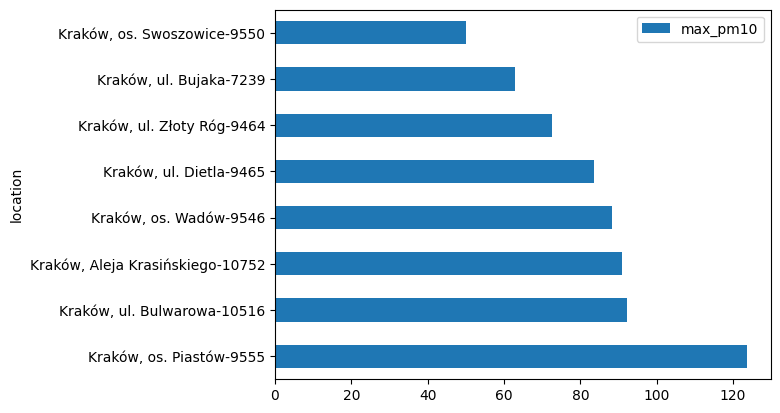

In [ ]:
plt.figure()
max_pm10.limit(10).toPandas().plot.barh(x='location')

### Zadanie 1

[1p.] Wczytaj dane dla kilkudziesięciu lokalizacji w Polsce z dłuższego okresu (na ile pozwoli pamięć) i znajdź spośród nich takie, w których średnie stężenie pyłu “pm10” było najwyższe (w całym badanym okresie). Wyniki posortuj malejąco po stężeniu pm10 i przedstaw na wykresie.


In [ ]:
locationsPL_df =locations_df.filter(locations_df.country_code == 'PL').select('name', 'id')
locationsPL_df.toPandas()
PL_location_ids = locationsPL_df.limit(50).select("id").rdd.flatMap(lambda x: x).collect() # limit do 50 lokalizacji z Polski

s3_paths = [
    f"s3a://openaq-data-archive/records/csv.gz/locationid={loc_id}/year=2022/month={{05,06}}/*.csv.gz"
    for loc_id in location_ids
    for year in [2022, 2023]
    for month in [5, 6]
]

smog_df = spark \
    .read \
    .format("csv") \
    .option("compression", "gzip") \
    .option("header", True) \
    .load(s3_paths)

smog_df = smog_df.withColumn("value", smog_df.value.cast('double'))

from pyspark.sql.functions import avg

poland_pm10 = smog_df.filter((col('parameter') == 'pm10') & (col('value') > 0.0))\
                  .groupby('location')\
                  .agg(avg('value').alias('avg_pm10'))\
                  .orderBy(desc('avg_pm10'))

# poland_pm10.limit(100).show(truncate=False) -> opcjonalnie
plt.figure()
poland_pm10.limit(10).toPandas().plot.barh(x = 'location')

### Zadanie 2

[1p.] Stwórz zapytanie, które dla każdej lokalizacji oblicza średnie stężenie wybranego parametru dla każdej godziny dnia (0-1, 1-2, ..., 23-24) i znajduje godzinę, w których średnia ta była najwyższa. Wyniki przedstaw na wykresie.

In [ ]:
# dla wybranego parametru pm10
smog_df_hours = smog_df\
              .filter((col('parameter') == 'pm10') & (col('value') > 0.0))\
              .withColumn('hour', hour(col('date.local')))

avg_by_hour = smog_df_hours.groupBy('location', 'hour')\
              .agg(avg('value').alias('avg_pm10'))

from pyspark.sql.window import Window
from pyspark.sql.functions import row_number

window = Window.partitionBy("location").orderBy(desc('avg_pm10'))

peak_hour = avg_by_hour\
    .withColumn("rank", row_number().over(window)) \
    .filter(col("rank") == 1)\
    .select("location", "hour", "avg_pm10")\
    .orderBy("hour")

peak_hour_df = peak_hour.toPandas()

plt.figure()
plt.barh(peak_hour_df['location'], peak_hour_df['hour'])

### Zadanie 3

[1p.] Stwórz wariant zapytania z zadania 2, który grupuje po dniach tygodnia (Pn-Nd). Dla każdej lokalizacji znajdź najwyższe średnie stężenie wybranego parametru w danym dniu tygodnia i wyniki posortuj malejąco. Wyniki przedstaw na wykresie.


In [ ]:
from pyspark.sql.functions import col, avg, desc, dayofweek, when
pm10_by_week = smog_df.filter((col('parameter') == 'pm10') & (col('value') > 0.0))\
                  .withColumn('weekday_num', dayofweek(col('date.local')))

pm10_by_week = pm10_by_week.withColumn('weekday',
    when(col('weekday_num') == 1, "Nd")
    .when(col('weekday_num') == 2, "Pn")
    .when(col('weekday_num') == 3, "Wt")
    .when(col('weekday_num') == 4, "Śr")
    .when(col('weekday_num') == 5, "Cz")
    .when(col('weekday_num') == 6, "Pt")
    .when(col('weekday_num') == 7, "So")
)

avg_by_weekday = pm10_by_week.groupBy('location', 'weekday')\
                .agg(avg('value').alias('avg_pm10'))


window = Window.partitionBy('location').orderBy(desc('avg_pm10'))

peak_day = avg_by_weekday\
          .withColumn('rank', row_number().over(window))\
          .filter(col('rank') == 1)\
          .select('location', 'weekday', 'avg_pm10')\
          .orderBy(desc('avg_pm10'))

peak_day_df = peak_day.toPandas()
plt.barh(peak_day_df['location'], peak_day_df['avg_pm10'])